***
# <span style='color:Blue'>Smartphone recommendations system</span>
***

## <span style='color:Blue'>Import the required packages</span>

In [1]:
import pandas as pd              # Perform operations on data frames
import numpy as np               # Perform numeric operations on data
import matplotlib.pyplot as plt  # For static visualizations
%matplotlib inline 
import seaborn as sns            # For advanced visualizations
import math
import scipy.stats as stats      # To perform statistical operations
from scipy.stats import zscore
from numpy import array
import warnings
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

#import the sklearn packages
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


#import surprise packages associated with recommendation system 
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from collections import defaultdict
from surprise import Dataset, Reader
from surprise import SVD
from surprise import KNNWithMeans
from surprise import accuracy
#from surprise import evaluate, print_perf

from rake_nltk import Rake
from numpy import array
from numpy import diag
from numpy import dot
from scipy.linalg import svd

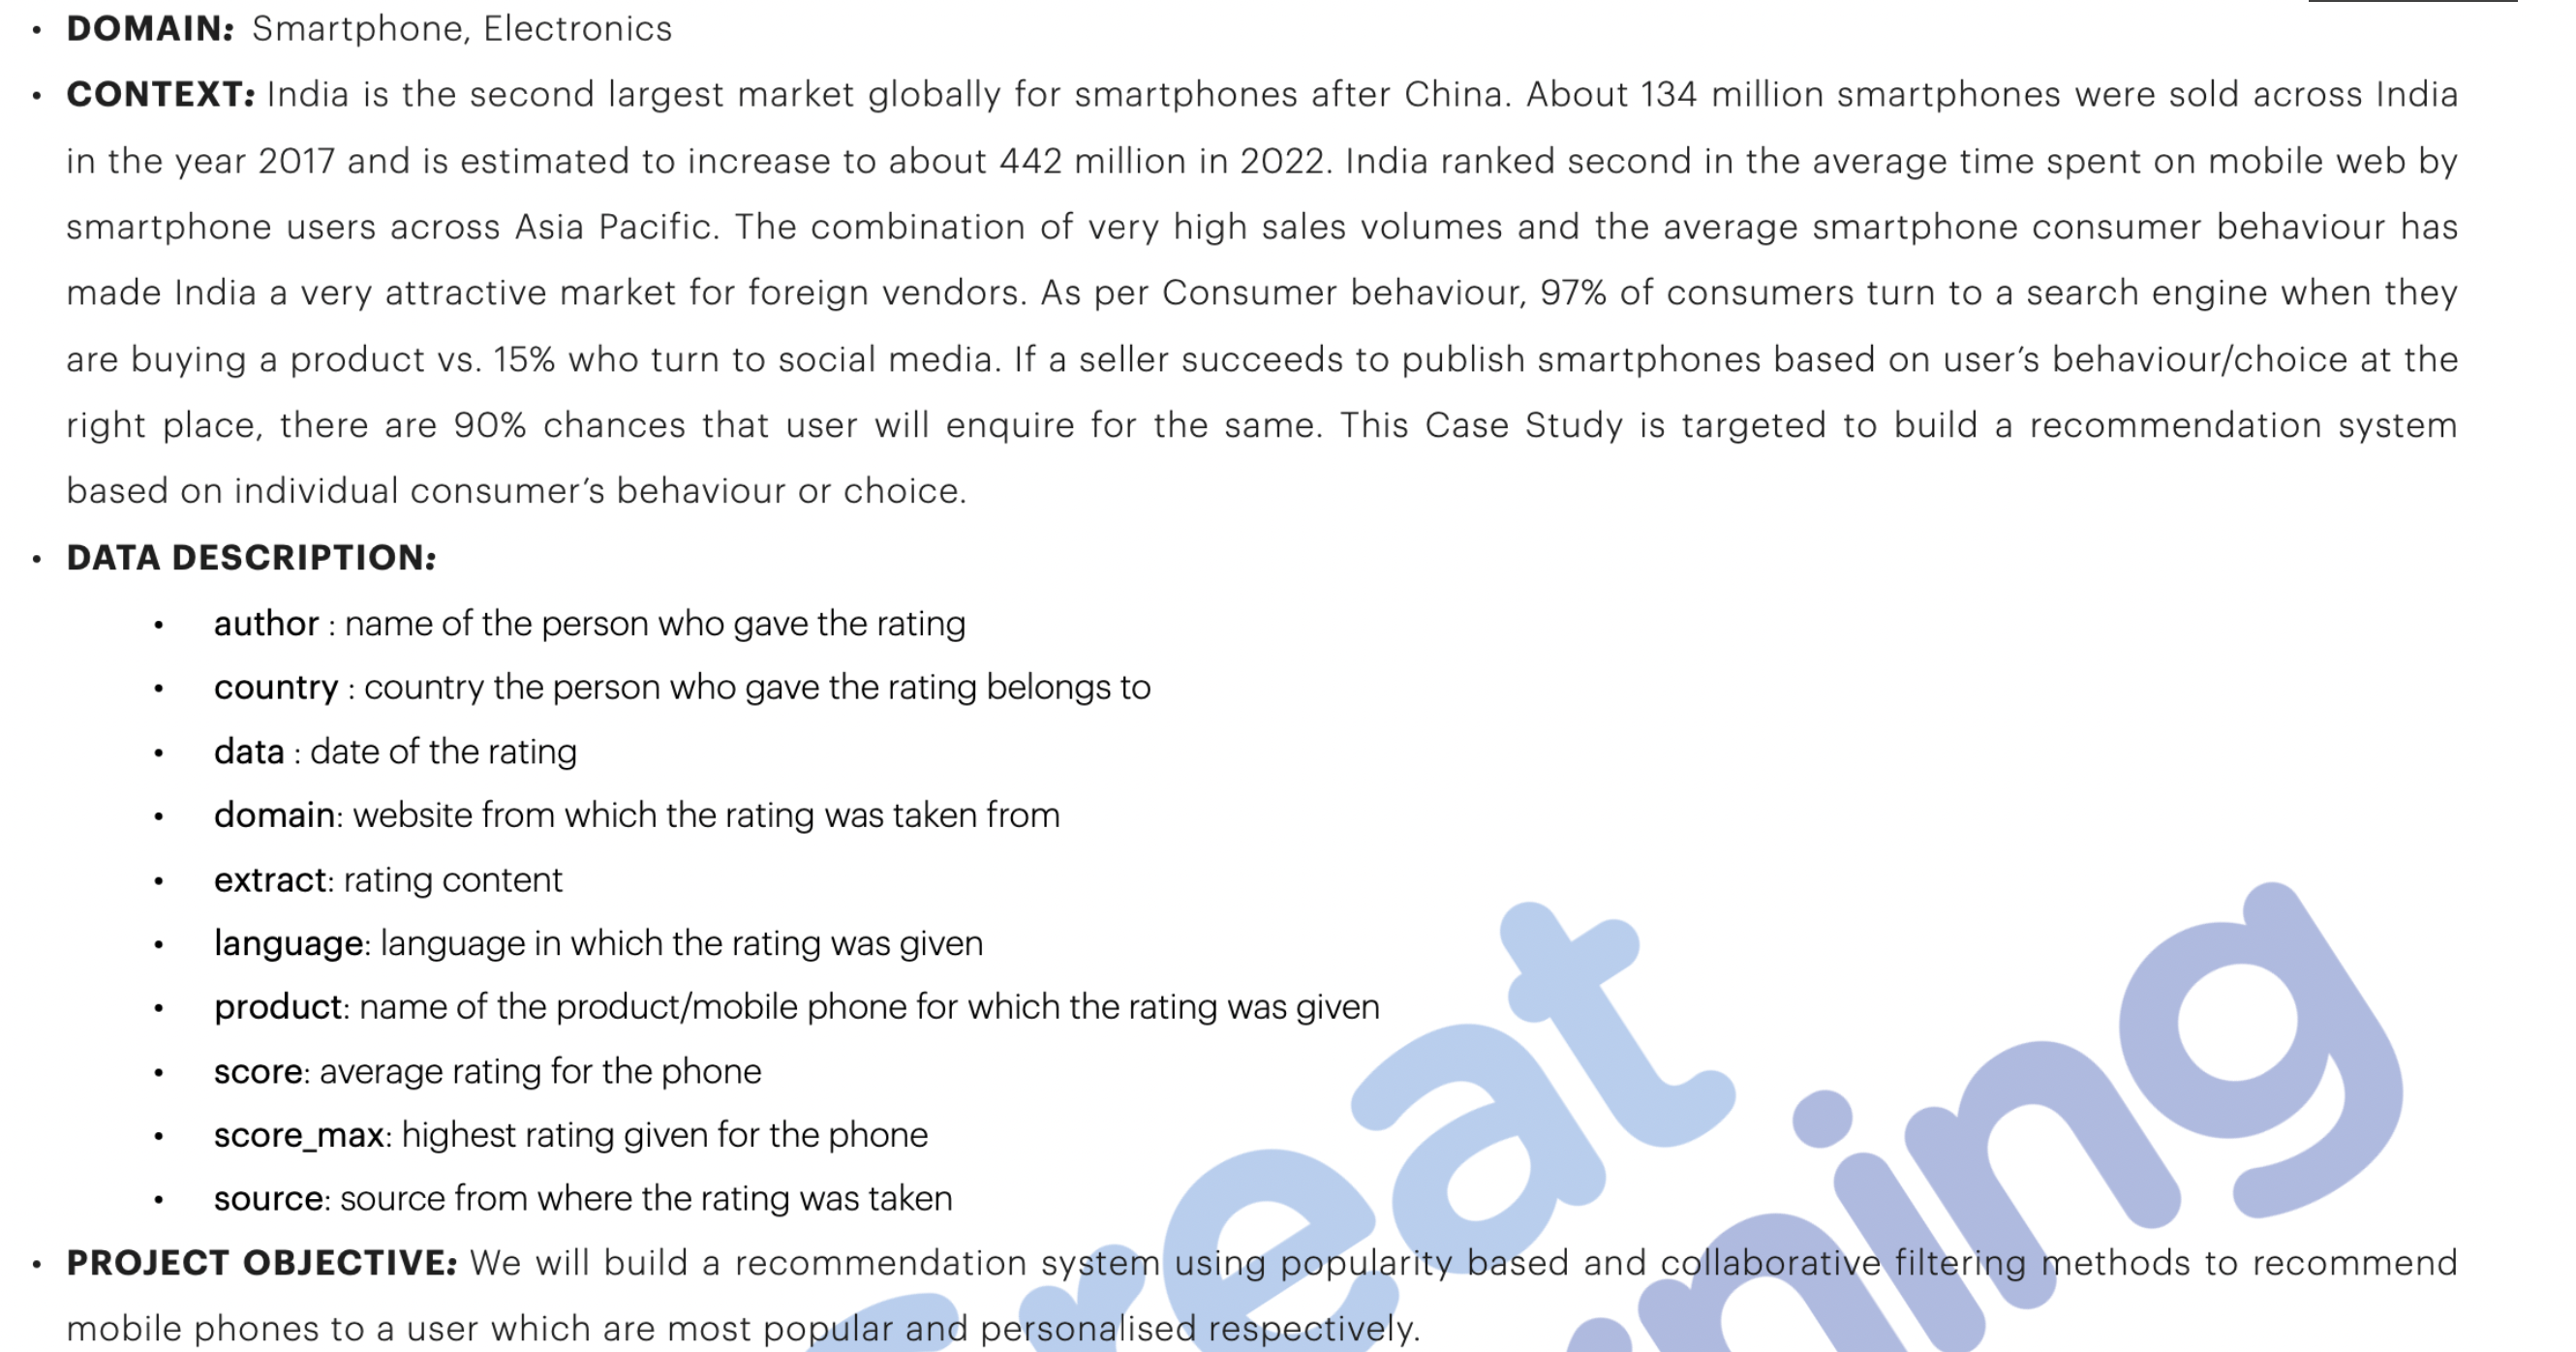

### Import the necessary libraries and read the provided CSVs as a data frame

### Merge all the provided CSVs into one dataFrame

In [2]:
#Read each of the csv files into respective data frames
df1 = pd.read_csv("Data Set/phone_user_review_file_1.csv", encoding='latin')
df2 = pd.read_csv("Data Set/phone_user_review_file_2.csv", encoding='latin')
df3 = pd.read_csv("Data Set/phone_user_review_file_3.csv", encoding='latin')
df4 = pd.read_csv("Data Set/phone_user_review_file_4.csv", encoding='latin')
df5 = pd.read_csv("Data Set/phone_user_review_file_5.csv", encoding='latin')

In [3]:
#Merge all the data frames into a single data frame
frames = [df1, df2, df3, df4, df5]
df_merge = pd.concat(frames)

In [4]:
#Make a copy of the original merged dataframe
df_original_copy = df_merge.copy()

In [5]:
df_merge.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [6]:
#Check the shape of the merged dataframe
original_shape = df_merge.shape
original_shape

(1251296, 11)

### Explore, understand the Data and share observations

In [7]:
#Check randomly sampled data
df_merge.sample(5)

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
69470,/cellphones/yu-yuphoria/,6/12/2015,en,in,Amazon,amazon.in,2.0,10.0,I bought this phone on 9oct and they gave me a...,Binod B.,YU Yuphoria YU5010A (Black+Silver)
195366,/cellphones/huawei-honor-6/,10/30/2014,en,gb,Amazon,amazon.co.uk,8.0,10.0,I had not heard of this brand. It seems to be ...,S. B. Kelly,"Honor 6 4G UK Smartphone (5 inch, Touchscreen,..."
52849,/cellphones/apple-iphone-5s/,3/11/2014,ru,ru,Yandex,market.yandex.ru,8.0,10.0,"ÐÐ¾ÑÐ²Ð¸Ð»ÑÑ Ð½Ð° ÐÐ, ÑÐº Ð¼Ð¾Ñ 4ÐºÐ° ...",Komarova Sabina,Apple iPhone 5S 64Gb
244996,/cellphones/nokia-3710-fold/,3/19/2010,ru,ru,Yandex,market.yandex.ru,10.0,10.0,Ð Ð¾Ð·Ð¾Ð²ÑÐ¹ Ð¸ Ð¿ÑÐµÐºÑÐ°ÑÐ½ÑÐ¹ ÑÐµÐ»Ð...,barmaleikah,Nokia 3710 Fold
354264,/cellphones/samsung-galaxy-s5/,6/7/2014,fr,fr,Amazon,amazon.fr,10.0,10.0,J'ai reÃ§u le tÃ©lÃ©phone le lendemain de la c...,CHERTIER,Samsung Galaxy S5 Blanc 4G Garantie Europeenne...


In [8]:
#Check datatypes and count of missing values
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251296 entries, 0 to 350215
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   phone_url  1251296 non-null  object 
 1   date       1251296 non-null  object 
 2   lang       1251296 non-null  object 
 3   country    1251296 non-null  object 
 4   source     1251296 non-null  object 
 5   domain     1251296 non-null  object 
 6   score      1199479 non-null  float64
 7   score_max  1199479 non-null  float64
 8   extract    1234823 non-null  object 
 9   author     1201151 non-null  object 
 10  product    1251295 non-null  object 
dtypes: float64(2), object(9)
memory usage: 114.6+ MB


In [9]:
# percentage of missing values in each column
round(df_merge.isnull().sum() / df_merge.isnull().count() * 100, 2)

phone_url    0.00
date         0.00
lang         0.00
country      0.00
source       0.00
domain       0.00
score        4.14
score_max    4.14
extract      1.32
author       4.01
product      0.00
dtype: float64

In [10]:
#statistical five point summary
df_merge.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
score,1199479.0,8.050337,2.622776,0.2,8.0,10.0,10.0,10.0
score_max,1199479.0,10.000000,0.000000,10.0,10.0,10.0,10.0,10.0


#### Check the variations in the name of the technically same product

In [11]:
df_merge.loc[df_merge['product'].str.contains(pat= 'Apple Iphone 7', regex=False, na=False),'product'].unique()

array(['Apple Iphone 7 plus 32GB Rose Gold GSM/CDMA Unlocked A1661 model',
       'Apple Iphone 7 Iphone 7 GSM 256GB - US warranty (Retail Packaging) LTE Bands 1, 2, 3, 4, 5, 7, 8, 12, 13, 17, 18, 19, 20, 25, 26, 27, 28, 29, 30) (Jet Black)',
       'Apple Iphone 7 Smartphone DÃ©bloquÃ© 4G (Ecran: 4,7 pouces - 32Go - Carte Nano-SIM - iOS) Black (Import Europe)',
       'Apple Iphone 7 Smartphone DÃ©bloquÃ© 4G (Ecran: 4,7 pouces - 32Go - Carte Nano-SIM - iOS) Rose Gold (Import Europe)',
       'Apple Iphone 7 128GB Oro Libre',
       'Apple Iphone 7 Smartphone DÃ©bloquÃ© 4G (Ecran: 4,7 pouces - 32Go - Carte Nano-SIM - iOS) Gold (Import Europe)',
       'Apple Iphone 7 128GB gold DE'], dtype=object)

#### <span style='color:Blue'>Observations</span>
- Though the product is technically the same i.e. `Apple Iphone 7`, we have a variable product description due to additional description such as 
    - Colors : Rose Gold, Black
    - Special characters : 'DÃ©bloquÃ©'
    - LTE bands info
    
- On the other hand, the column `phone_url` also contains the concise/clean technical names of smartphones, which can be used to avoid irrelevant details in the `product` column

In [12]:
# print the frequency count of phone_url column
df_merge['phone_url'].value_counts(ascending=False).head(20)

/cellphones/samsung-galaxy-s-iii/                                 17093
/cellphones/apple-iphone-5s/                                      16379
/cellphones/samsung-galaxy-s6/                                    16145
/cellphones/samsung-galaxy-s5/                                    16082
/cellphones/samsung-galaxy-s7-edge/                               15917
/cellphones/motorola-moto-g/                                      14476
/cellphones/samsung-galaxy-s7-789999/                             13488
/cellphones/samsung-i9500-galaxy-s-iv/                            13161
/cellphones/huawei-p8-lite/                                       12629
/cellphones/lenovo-vibe-k4-note/                                   9662
/cellphones/samsung-galaxy-s4-mini-gt-i9190-gt-i9192-dual-sim/     9027
/cellphones/samsung-galaxy-s6-edge-sm-g925f/                       8844
/cellphones/apple-iphone-4s/                                       8602
/cellphones/samsung-galaxy-s3-mini/                             

In [13]:
#Count of unique rows in the data frame
df_unique = df_merge.drop_duplicates()
len(df_unique)

1245533

### Check if the same user/author has rated the same product multiple times due to general names in the author field such as `Amazon Customer`

In [14]:
sameAuthorProducts = df_merge.loc[df_merge[['author', 'product']].duplicated(), ['author', 'product']].sort_values(by=['author','product'])

In [15]:
amazonCustProducts = sameAuthorProducts[sameAuthorProducts['author'] == 'Amazon Customer']

In [16]:
amazonCustProductsCount = amazonCustProducts['product'].value_counts().to_frame().reset_index().rename(columns={'index':'product', 'product':'count'})
topAmazonCustProductsCount_100 = amazonCustProductsCount[amazonCustProductsCount['count'] > 100].reset_index(drop=True)

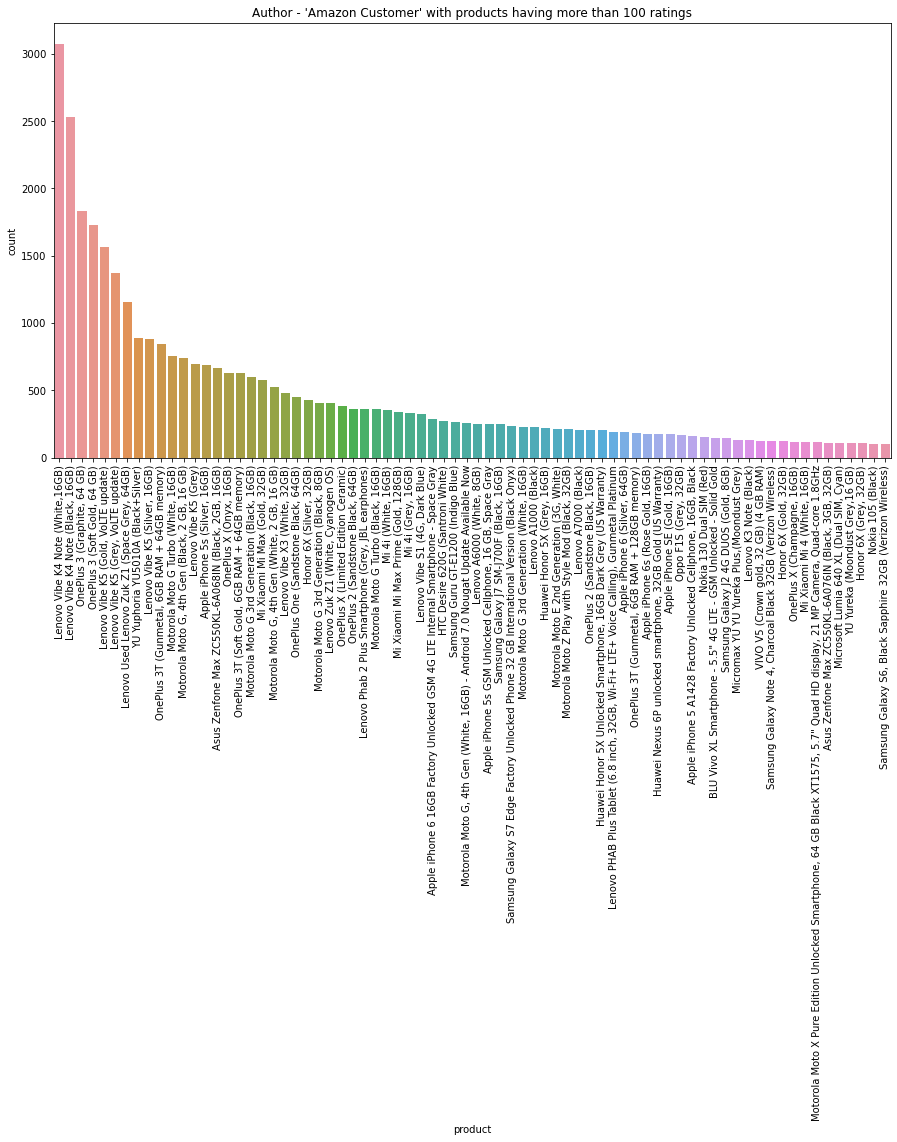

In [17]:
plt.figure(figsize=(15,8))
sns.barplot(data=topAmazonCustProductsCount_100, x='product', y='count')
plt.xticks(rotation=90)
plt.title("Author - 'Amazon Customer' with products having more than 100 ratings")
plt.show()

#### <span style='color:Blue'>Observations</span>
- Ideally we should have a single rating for a given product by the single author
- However due to generic or unknown authors (e.g. Amazon Customer), we can see that there are multiple ratings for the same 'product' with the same 'author'

In [18]:
sameAuthorProducts[sameAuthorProducts['author'] == 'Amazon Customer'].shape

(68187, 2)

In [19]:
sameAuthorProducts[sameAuthorProducts['author'] == 'Amazon Customer'].drop_duplicates().shape

(4576, 2)

#### <span style='color:Blue'>Observations</span>
- By Summarizing redundant 'author', 'product' entries, we can reduce the data dimensinality significantly. As shown here, for the author `Amazon Customer` we can end up from 68142 product/ratings to 4574, i.e. close to ~15 fold reduction

In [20]:
# Statistical Summary of product counts by Amazon Customer
amazonCustProductsCount.describe()

,count
count,4576.000000
mean,14.901005
std,90.742492
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,3077.000000


In [21]:
topAmazonCustProductsCount_100.head()

,product,count
0,"Lenovo Vibe K4 Note (White,16GB)",3077
1,"Lenovo Vibe K4 Note (Black, 16GB)",2531
2,"OnePlus 3 (Graphite, 64 GB)",1830
3,"OnePlus 3 (Soft Gold, 64 GB)",1726
4,"Lenovo Vibe K5 (Gold, VoLTE update)",1567


#### <span style='color:Blue'>Observations</span>
- The most rated product by `Amazon Customer` is `Lenovo Vibe K4 Note 16 GB` but its been labelled differently for `White` and `Black` color models
- Same can be observed for the next most rated product by `Amazon Customer` i.e. `OnePlus 3 64 GB`

#### <span style='color:Blue'>Conclusions from Data Exploration</span>
- All the features are of object data type except score and score_max which are of float type. 
- It should also be noted that the date column is also of object type, which ideally should be of datetime type.
- From the five point summary, it is noted that the minimum score is 0.2 and average score is 8. `score_max` has a maximum score 10 for all the products.
- There are missing values in score, score_max extract, author and product columns. The missing value percentage in score and score_max is 4.14, author is 4.01 and extract is 1.32 and product has 1 missing value so its % is close to 0.
- It is observed that same product has different names due to unnecessarily added specifications and special characters.
- Also there are multiple ratings for the same product by the same generic author such as `Amazon Customer`.

### Round off scores to the nearest integers

In [22]:
#Convert the score and score_max features to integer
df_merge['score'] = df_merge['score'].round().astype('Int64')
df_merge['score_max'] = df_merge['score_max'].round().astype('Int64')

In [23]:
df_merge.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10,10,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10,10,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6,10,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9,10,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4,10,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [24]:
df_merge[['score']].describe()

,score
count,1.199479e+06
mean,8.051438e+00
std,2.624320e+00
min,0.000000e+00
25%,8.000000e+00
50%,1.000000e+01
75%,1.000000e+01
max,1.000000e+01


#### <span style='color:Blue'>Observations</span>
- It can be seen that minimum score has become zero after imputation for some of the products. 
- In the original data we had 0.2 as the minimum score, not zero. 
- So in such cases lets make the score to minimum of 1

In [25]:
df_merge.loc[df_merge['score'] == 0, 'score'] = 1

In [26]:
#Confirm the data type after conversion for score anf score_max features
df_merge.dtypes

phone_url    object
date         object
lang         object
country      object
source       object
domain       object
score         Int64
score_max     Int64
extract      object
author       object
product      object
dtype: object

### Check for missing values. Impute the missing values, if any

In [27]:
#Count of missing values in each column/feature
df_merge.isnull().sum()

phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score        51817
score_max    51817
extract      16473
author       50145
product          1
dtype: int64

In [28]:
#Impute the numeric missing values with their median values for score and score_max column.
df_merge[['score', 'score_max']] = df_merge[['score', 'score_max']].fillna(df_merge[['score', 'score_max']].median())

In [29]:
#Impute the categorial missing values with their most frequent i.e mode values
df_merge['extract'].fillna(df_merge['extract'].mode()[0], inplace = True)
df_merge['author'].fillna(df_merge['author'].mode()[0], inplace = True)

#### <span style='color:Blue'>Comment</span>
- As described in the Q1B, there is unnecessary decsription and unwanted characters in the `product` column. 
- However, the `phone_url` column provides the clean & concise names for products. 
- Thus we can use the phone_url column to derive and/or impute clean product names

In [30]:
df_merge[df_merge['product'].isna()]

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
312960,/cellphones/samsung-galaxy-s-iii/,1/22/2014,de,de,Amazon,amazon.de,10,10,Bestes Smartphone was ich bisher hatte :) Ã¶af...,Amazon Customer,NaN


In [31]:
#Create a new product column by fetching from the phone url 
df_merge['product_clean'] = df_merge['phone_url'].str.split("/").apply(lambda col: col[2]).replace('-', ' ', regex=True)

In [32]:
df_merge['product'].nunique(), df_merge['product_clean'].nunique(), df_merge['phone_url'].nunique()

(52239, 3198, 3198)

#### <span style='color:Blue'>Observations</span>
- It can be seen that from the `phone_url` we have 3198 unique products, however just due to variation in the description in `product` column we got 52239 products.
- Generally on e-commerce website the main goal is to recommend the product, the sub specifications of the product are offered subsequently by default. For example, when user looks for Apple Iphone 7, the website also shows color,  memory (64GB 128GB) variants, etc. 
- So, the main focus of the recommendation system should be on the actual product.
- Hence, we use the phone_url column to derive and/or impute clean product names.

In [33]:
# Retain the original product information in 'product_original' column and
# Assign clean names in `product_clean` to `product` column
df_merge['product_original'] = df_merge['product']
df_merge['product'] = df_merge['product_clean']
df_merge.drop(columns=['product_clean'], inplace=True)

In [34]:
#confirm the missing values post imputation
df_merge.isnull().sum()

phone_url           0
date                0
lang                0
country             0
source              0
domain              0
score               0
score_max           0
extract             0
author              0
product             0
product_original    1
dtype: int64

**Note**
- Please note that `product_original` column retains the original product names, which contained one missing value
- However, we will be using newly created `product` column for subsequent analysis

### Check for duplicate values and remove them, if any.

#### Check if we have any duplicate rows

In [35]:
#Count of duplicate rows in the data frame
len(df_merge[df_merge.duplicated()])

5828

In [36]:
#Remove the duplicate rows
df_merge.drop_duplicates(inplace=True)

In [37]:
# Shape of data after removing duplicate rows
df_merge.shape

(1245468, 12)

#### Check if we have any duplicate products rated by the same author, as described in 1B.

In [38]:
df_merge[['author', 'product', 'score']].duplicated().sum()

231823

In [39]:
df_merge[['author', 'product', 'score']].drop_duplicates().shape

(1013645, 3)

In [40]:
# Remove the duplicates based on the relevant features to be used in subsequent analyses
df_merge_removed_dup = df_merge.drop_duplicates(subset=['author', 'product', 'score'], keep='first')

In [41]:
df_merge_removed_dup.shape

(1013645, 12)

### Keep only 1 Million data samples. Use random state=612

In [42]:
#subsample the data to 1M using random state 612
df_sampled = df_merge_removed_dup.sample(n=1000000,random_state=612)

In [43]:
len(df_sampled)

1000000

### Drop irrelevant features. Keep features like Author, Product, and Score.

In [44]:
#Irrelevant features to drop
cols_to_drop = ['phone_url','date','lang','country','source','domain','score_max','extract','product_original']

In [45]:
#Relevant features retained from the original imputed data
relevant_features  = df_merge_removed_dup.drop(columns = cols_to_drop )

In [46]:
#Reordering the relevant columns
relevant_features = relevant_features[['author','product','score']]

In [47]:
relevant_features

,author,product,score
0,CarolAnn35,samsung galaxy s8,10
1,james0923,samsung galaxy s8,10
2,R. Craig,samsung galaxy s8,6
3,Buster2020,samsung galaxy s8,9
4,S Ate Mine,samsung galaxy s8,4
...,...,...,...
350201,Sven P.,sony ericsson z710i,10
350202,Moran,sony ericsson z710i,10
350203,Torsten,sony ericsson z710i,8
350206,Zell,sony ericsson z710i,10


In [48]:
relevant_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1013645 entries, 0 to 350208
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   author   1013645 non-null  object
 1   product  1013645 non-null  object
 2   score    1013645 non-null  Int64 
dtypes: Int64(1), object(2)
memory usage: 31.9+ MB


## Identify the most rated products

### Using sampled data with relevant features as mentioned above for subsequent analyses

In [49]:
relevant_features_sampled = df_sampled[['author','product','score']]

In [50]:
relevant_features_sampled.shape

(1000000, 3)

In [51]:
# Count the rating provided for each of the products
product_review = pd.DataFrame(relevant_features_sampled['product'].value_counts().reset_index().rename(columns={'index':'product','product':'count'}))

In [52]:
product_review.head()

,product,count
0,samsung galaxy s5,13017
1,samsung galaxy s6,12590
2,motorola moto g,11829
3,samsung galaxy s7 edge,11790
4,apple iphone 5s,11667


- Based on the number of ratings **_samsung galaxy s5_**, **_samsung galaxy s6_** and **_motorola moto g_** are the top 3 products with most ratings.

### Identify the users with most number of reviews

In [53]:
# Count the rating provided by each user
user_review = pd.DataFrame(relevant_features_sampled['author'].value_counts()).reset_index().rename(columns={'index':'author','author':'count'})

In [54]:
user_review.head(10)

,author,count
0,Amazon Customer,8226
1,Cliente Amazon,1880
2,Amazon Kunde,1265
3,Client d'Amazon,1113
4,Anonymous,980
5,David,596
6,Alex,549
7,Daniel,517
8,Marco,491
9,Andrea,481


- Based on the above analysis, authors/users who gave the ratings/reviews maximum number of times are from **_Amazon Customer_** followed by **_Cliente Amazon_** and **_Amazon Kunde_**. 

### Select the data with products having more than 50 ratings and users who have given more than 50 ratings. Report the shape of the final dataset.

In [55]:
# Filter users with >50 ratings
user_gt_50 = user_review.loc[user_review['count'] > 50, 'author']

In [56]:
# Filter products with >50 ratings
product_gt_50 = product_review.loc[product_review['count'] > 50, 'product']

In [57]:
# Find the products and authors with >50 ratings
relevant_features_gt50 = relevant_features_sampled[(relevant_features_sampled['product'].isin(product_gt_50)) & 
                  (relevant_features_sampled['author'].isin(user_gt_50))]

In [58]:
#Shape of the final dataset
relevant_features_gt50.shape

(87666, 3)

In [59]:
#Info of the final dataset
relevant_features_gt50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87666 entries, 63924 to 170229
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   87666 non-null  object
 1   product  87666 non-null  object
 2   score    87666 non-null  Int64 
dtypes: Int64(1), object(2)
memory usage: 2.8+ MB


## Build a popularity based model and recommend top 5 mobile phones.

In [60]:
#Calculating average score per product
score_mean_count = pd.DataFrame(relevant_features_gt50.groupby('product')['score'].mean()) 

In [61]:
#Calculating count of ratings per product
score_mean_count['rating_counts'] = pd.DataFrame(relevant_features_gt50.groupby('product')['score'].count())  

In [62]:
# Filter products with at least 50 ratings
score_mean_count_50 = score_mean_count[score_mean_count['rating_counts'] > 50 ]

In [63]:
score_mean_count_50.sort_values(by= ['score', 'rating_counts'],ascending=False).head(5)

,score,rating_counts
product,,
samsung galaxy mega 6 3 i9200,9.076923,65
huawei honor 8,8.945312,128
samsung ativ s,8.914286,105
huawei ascend honor 3c,8.907216,97
lg optimus g,8.888889,54


- Based on the highest score (Average rating) and rating_counts (total ratings provided by users, > 50) the top 5 products identified through popularity based model are shown above.

### Build a collaborative filtering model using SVD and kNNWithMeans from surprise.Check both user-based and item-based model

### SVD Based Recommendation System¶

In [64]:
# Initialize random state to ensure reproducibilty of the analysis
randomState = 41

In [65]:
# Load the data as a Surprise dataset
reader = Reader(rating_scale=(1, 10))
data_mod = Dataset.load_from_df(relevant_features_gt50[['author', 'product', 'score']], reader)

In [66]:
# Split the data into train and test set 
trainset, testset = train_test_split(data_mod, test_size=.25,random_state=randomState)

In [67]:
# Fit the model using the train set
svd_model = SVD(n_factors=5,biased=True, random_state =randomState)
svd_model.fit(trainset)

In [68]:
# Convert a trainset data in testable format using the build_testset()
data_trainset = trainset.build_testset()

In [69]:
# Predict the ratings for the train dataset
svd_train_pred = svd_model.test(data_trainset)
svd_train_accuracy = accuracy.rmse(svd_train_pred, verbose=False)
print("RMSE of train set using SVD :", round(svd_train_accuracy, 2))

RMSE of train set using SVD : 2.39


In [70]:
# Predict the ratings for the test dataset
svd_test_pred = svd_model.test(testset)
svd_test_accuracy = accuracy.rmse(svd_test_pred, verbose=False)
print("RMSE of test set using SVD :", round(svd_test_accuracy, 2))

RMSE of test set using SVD : 2.73


### KNNWithMeans

In [71]:
# Set the number of minimum neighbors for collaborative filtering
neighbors = 50

### User-User Collaborative filtering

In [72]:
# Initialize KNNWithMeans for User-User based collaborative filtering
algo_user = KNNWithMeans(k=neighbors, sim_options={'user_based': True},random_state=randomState, verbose=False)
algo_user.fit(trainset)

In [73]:
# Predict the ratings for the train dataset
train_pred_user = algo_user.test(data_trainset)
knn_user_train_accuracy = accuracy.rmse(train_pred_user, verbose=False)
print("RMSE for train set using KnnWithMeans user-user based collabartive filtering :", round(knn_user_train_accuracy, 2))

RMSE for train set using KnnWithMeans user-user based collabartive filtering : 1.91


In [74]:
# Predict the ratings for the test dataset
test_pred_user = algo_user.test(testset)
knn_user_test_accuracy = accuracy.rmse(test_pred_user, verbose=False)
print("RMSE for test set using KnnWithMeans user-user based collabartive filtering :", round(knn_user_test_accuracy, 2))

RMSE for test set using KnnWithMeans user-user based collabartive filtering : 2.81


### Item-Item Collaborative filtering

In [75]:
# Initialize KNNWithMeans for Item-Item based collaborative filtering
algo_item = KNNWithMeans(k=neighbors, sim_options={'user_based': False}, random_state=randomState, verbose=False)
algo_item.fit(trainset)

In [76]:
# Predict the ratings for the train dataset
train_pred_item = algo_item.test(data_trainset)
knn_item_train_accuracy = accuracy.rmse(train_pred_item, verbose=False)
print("RMSE for train set using KnnWithMeans item-item based collabartive filtering :", round(knn_item_train_accuracy, 2))

RMSE for train set using KnnWithMeans item-item based collabartive filtering : 1.96


In [77]:
# Predict the ratings for the test dataset
test_pred_item = algo_item.test(testset)
knn_item_test_accuracy = accuracy.rmse(test_pred_item, verbose=False)
print("RMSE for test set using KnnWithMeans item-item based collabartive filtering :", round(knn_item_test_accuracy, 2))

RMSE for test set using KnnWithMeans item-item based collabartive filtering : 2.84


### Evaluate the collaborative model. Print RMSE value.

In [78]:
models_summary = pd.DataFrame({
    "Model" : ['SVD', 'KnnWithMeans_Item-Item', 'KnnWithMeans_User-User'],
    "Train RMSE" : [svd_train_accuracy, knn_item_train_accuracy, knn_user_train_accuracy],
    "Test RMSE" : [svd_test_accuracy, knn_item_test_accuracy , knn_user_test_accuracy]
    }).sort_values(by="Test RMSE", ascending=True).reset_index(drop=True)

In [79]:
models_summary

,Model,Train RMSE,Test RMSE
0,SVD,2.394857,2.734650
1,KnnWithMeans_User-User,1.914337,2.805302
2,KnnWithMeans_Item-Item,1.964393,2.837663


#### <span style='color:Blue'>Observations</span>
- Based on the RMSE values obtained for Test data set, SVD method found to give better results for predicting ratings
- Both KNNWithMeans collaboraive filtering approaches (user and item-based) show similar RMSE ~2.8

#### Visualization of the SVD-based prediction output on Test set 

In [80]:
svd_test_pred_df=pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [81]:
svd_test_pred_df.head()

,uid,iid,rui,est,details
0,Nicolas,google nexus 6p,8.0,8.579438,{'was_impossible': False}
1,Amazon Customer,samsung b5722,10.0,5.372886,{'was_impossible': False}
2,Cliente Amazon,cat s30,6.0,5.061345,{'was_impossible': False}
3,Alexandre,samsung galaxy s6 edge sm g925f,10.0,7.508261,{'was_impossible': False}
4,michele,samsung galaxy j5,8.0,7.894588,{'was_impossible': False}


### Predict score (average rating) for test users.

In [82]:
#Average Rating estimated using SVD for test users
svd_test_pred_df = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
print('average prediction for test users using SVD: ',svd_test_pred_df['est'].mean())

average prediction for test users using SVD:  7.839119423923343


In [83]:
#Average Rating estimated using KnnwithMeans item-item based collaborative filtering for test users
test_pred_item_df = pd.DataFrame(test_pred_item, columns=['uid', 'iid', 'rui', 'est', 'details'])
print('average prediction for test users using item-item based CF:', test_pred_item_df ['est'].mean())

average prediction for test users using item-item based CF: 7.7618970444914455


In [84]:
#Average Rating estimated using KnnwithMeans user-user based collaborative filtering for test users
test_pred_user_df = pd.DataFrame(test_pred_user, columns=['uid', 'iid', 'rui', 'est', 'details'])
print('average prediction for test users using item-item based CF:', test_pred_user_df ['est'].mean())

average prediction for test users using item-item based CF: 7.815947201585477


### Report your findings and inferences

- The product with the maximum number of ratings is **_samsung galaxy s5_**
- The author who provided the maximum number of ratings is **_Amazon Customer_**
- The most popular product with high rating score by maximum number of users is **_samsung galaxy mega 6 3 i9200_** using popularity based recommendation system.
- The RMSE value predicted by different collaborating filtering model is approximately **_2.8_**.
- The estimated average ratings by the test users using svd and knnmeans is approximately **_7.8_**  

### Try and recommend top 5 products for test users

In [85]:
# Function to Obtain top n recommendation for each user
def getTopPredictions(predictions, n=5):
    # Store the predicted ratings of products for each user.
    topDict = defaultdict(list)
    for uid, iid, r_ui, est, _ in predictions:
        topDict[uid].append((iid, est))

    # Sort the predictions for each user and retrieve the top n highest rated.
    for uid, ratings in topDict.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topDict[uid] = ratings[:n]

    return topDict

In [86]:
topPredictions = getTopPredictions(svd_test_pred, n=5)

In [87]:
# Print author/user and top recommended products
for author, recommendations in topPredictions.items():
        print(author," ==> ", recommendations)
        print("\n###\n")

Nicolas  ==>  [('apple iphone 5c', 9.573760832580671), ('huawei honor 5x', 9.522629469412244), ('apple iphone 4s', 9.367332786396922), ('asus zenfone selfie zd551kl', 9.309445890345728), ('samsung galaxy note', 9.224000336464366)]

###

Amazon Customer  ==>  [('samsung galaxy note 4', 8.479994974439752), ('samsung galaxy note 4', 8.479994974439752), ('samsung galaxy note 4', 8.479994974439752), ('lg dare vx9700', 8.42500543084401), ('motorola moto z play', 8.3580608627659)]

###

Cliente Amazon  ==>  [('apple iphone 6 plus', 9.556878773730709), ('apple iphone 6 plus', 9.556878773730709), ('samsung galaxy s4 mini gt i9190 gt i9192 dual sim', 9.166145027039857), ('apple iphone 6', 8.656574512755107), ('apple iphone 5', 8.553847276493915)]

###

Alexandre  ==>  [('htc desire 610', 9.128831551644401), ('motorola moto e', 9.05462710123524), ('asus zenfone 3', 9.041162399414917), ('motorola moto x play', 8.757813058079591), ('samsung galaxy s7 789999', 8.476824728599107)]

###

michele  ==> 

In [88]:
# Get top 5 recommended products for each user based on predicted ratings
topPredictions_user_based = getTopPredictions(test_pred_user, n=5)
topPredictions_item_based = getTopPredictions(test_pred_item, n=5)

In [89]:
for author, recommendations in topPredictions_user_based.items():
        print(author," ==> ", recommendations)
        print("\n###\n")

Nicolas  ==>  [('huawei honor 7', 9.320768985466936), ('wiko rainbow', 9.19864248638851), ('huawei honor 5x', 9.158092585942336), ('doro phone easy 615', 9.149035524284871), ('apple iphone 4s', 9.083916736899836)]

###

Amazon Customer  ==>  [('lg d lite gd570', 9.942594962926666), ('lg gs170', 9.933336079655703), ('lg gs170', 9.933336079655703), ('pantech caper', 9.841919958593909), ('xolo q800', 9.822101920579748)]

###

Cliente Amazon  ==>  [('wiko highway', 9.27584016602405), ('wiko highway', 9.27584016602405), ('zte blade v6', 8.644658846709524), ('blackberry venice', 8.370334179179192), ('elephone trunk', 8.23977825319623)]

###

Alexandre  ==>  [('asus zenfone 3', 8.86240035777802), ('samsung galaxy s7 789999', 8.718483528553248), ('motorola moto x play', 8.51824681536125), ('motorola moto e', 8.420169781772426), ('htc desire s', 8.274134305226019)]

###

michele  ==>  [('huawei ascend p1', 9.193009819743185), ('nokia lumia 1320', 8.734239334512672), ('samsung galaxy s6', 8.5490

In [90]:
# Print author/user and top recommended products
for author, recommendations in topPredictions_item_based.items():
        print(author," ==> ", recommendations)
        print("\n###\n")
        

Nicolas  ==>  [('doro phone easy 615', 9.432763456650036), ('asus zenfone selfie zd551kl', 9.151643465456067), ('huawei honor 7', 8.846795116095771), ('apple iphone se', 8.64273729994638), ('samsung wave s8500', 8.559089433806795)]

###

Amazon Customer  ==>  [('lg p940', 10), ('karbonn s5 titanium', 10), ('samsung e2370', 10), ('sony ericsson w850i', 10), ('motorola v197', 10)]

###

Cliente Amazon  ==>  [('wiko highway', 10), ('wiko highway', 10), ('samsung galaxy j7', 9.539494882484487), ('blackberry z30', 9.266133656704099), ('blackberry z30', 9.266133656704099)]

###

Alexandre  ==>  [('asus zenfone 3', 8.788306889810247), ('motorola moto x play', 8.419261824323252), ('samsung galaxy s7 789999', 8.408277498701478), ('htc desire s', 8.358747661673215), ('nokia 5800 xpressmusic tube', 8.31613509410056)]

###

michele  ==>  [('nokia 2730 classic', 8.562678956127412), ('sony xperia z 504642', 8.511110767711706), ('nokia lumia 720', 8.447972349729746), ('sony xperia z1 compact d5503', 

### Try other techniques (Example: cross validation) to get better results

### Using cross validation and GridSearchCV techniques for performance improvements

#### Initialize the performance summary dataframe to store RMSE values

In [91]:
performanceSummary = pd.DataFrame({
    'Algorithm' : ['SVD', 'KNNWithMeans_User_based', 'KNNWithMeans_Item_based', 
                   'SVD', 'KNNWithMeans_User_based', 'KNNWithMeans_Item_based'],
    'Optimization technique' : ['Cross Validation', 'Cross Validation', 'Cross Validation',
                               'GridSearchCV', 'GridSearchCV', 'GridSearchCV'],
    'RMSE' : np.nan,
    'Best Parameters' : np.nan
})

In [92]:
rmse = []
bestParams = []

### SVD with Cross validation technique

In [93]:
randomState = 41
nfold = 10

In [94]:
svd = SVD(random_state=randomState)
svd_cv = cross_validate(svd, data_mod, measures = ['RMSE'], cv = nfold, verbose = False)

In [95]:
svd_cv_rmse = round(svd_cv['test_rmse'].mean(),2)
rmse.append(svd_cv_rmse)
bestParams.append('Default')
print('\n Mean RMSE for SVD with 10-fold Cross Validation:', svd_cv_rmse,'\n')


 Mean RMSE for SVD with 10-fold Cross Validation: 3.04 



### KNNWithMeans: User-User based collaborative filtering using Cross validation technique

In [96]:
neighbors = 50

In [97]:
knn_user = KNNWithMeans(k = neighbors, sim_options={'user_based': True}, random_state = randomState, verbose = False)
knn_user_cv = cross_validate(knn_user, data_mod, measures = ['RMSE'], cv = nfold, verbose = False)

In [98]:
knn_user_cv_rmse = round(knn_user_cv['test_rmse'].mean(),2)
rmse.append(knn_user_cv_rmse)
bestParams.append('Default')
print('\n Mean RMSE for KNNwithMeans (User-User based CF) with 10-fold Cross Validation:', knn_user_cv_rmse,'\n')


 Mean RMSE for KNNwithMeans (User-User based CF) with 10-fold Cross Validation: 2.8 



### KNNWithMeans: Item-Item based collaborative filtering using Cross validation technique

In [99]:
knn_item = KNNWithMeans(k = neighbors, sim_options={'user_based': False}, random_state = randomState, verbose = False)
knn_item_cv = cross_validate(knn_item, data_mod, measures = ['RMSE'], cv = nfold, verbose = False)

In [100]:
knn_item_cv_rmse = round(knn_item_cv['test_rmse'].mean(),2)
rmse.append(knn_item_cv_rmse)
bestParams.append('Default')
print('\n Mean RMSE for KNNwithMeans (Item-Item based CF) with 10-fold Cross Validation:', knn_item_cv_rmse,'\n')


 Mean RMSE for KNNwithMeans (Item-Item based CF) with 10-fold Cross Validation: 2.83 



### Hyperparameter Tuning using GridSearchCV for performance improvement

#### Declare methods and parameter grids with a few more algorithms

In [101]:
methodsDict = {
    'SVD' : [SVD, {'n_epochs': list(range(10,21)), 'biased' : [True, False], 'random_state' : [randomState], 'lr_all' : [0.005, 0.001,0.01,0.1], 'verbose' : [False]}],
    'kNNWithMeans_user':[KNNWithMeans, 
                {'k': list(range(30,51)), 
                'sim_options' : {'name': ['MSD','cosine', 'pearson','pearson_baseline'], 'user_based':[True]}, 'random_state' : [randomState], 'verbose' : [False]}],
    'kNNWithMeans_item': [KNNWithMeans,
                 {'k': list(range(30,51)), 
                'sim_options' : {'name': ['MSD', 'cosine', 'pearson','pearson_baseline'], 'user_based':[False]}, 'random_state' : [randomState], 'verbose' : [False]}]

}

In [102]:
for method, params in methodsDict.items():
    instance = methodsDict[method][0]
    param_grid = methodsDict[method][1]
    gsTemp = GridSearchCV(instance, param_grid, measures=['rmse'], cv = nfold)
    print(method)
    gsTemp.fit(data_mod)

    # best RMSE score
    print(gsTemp.best_score['rmse'])
    rmse.append(gsTemp.best_score['rmse'])

    # combination of parameters that gave the best RMSE score
    print(gsTemp.best_params['rmse'])
    bestParams.append(gsTemp.best_params['rmse'])
    
    print("\n####\n")

SVD
2.6229118102148856
{'n_epochs': 11, 'biased': True, 'random_state': 41, 'lr_all': 0.001, 'verbose': False}

####

kNNWithMeans_user
2.6853793542931212
{'k': 50, 'sim_options': {'name': 'cosine', 'user_based': True}, 'random_state': 41, 'verbose': False}

####

kNNWithMeans_item
2.7178391442080923
{'k': 50, 'sim_options': {'name': 'cosine', 'user_based': False}, 'random_state': 41, 'verbose': False}

####



In [103]:
performanceSummary['RMSE'] = rmse
performanceSummary['Best Parameters'] = bestParams
performanceSummary_sorted = performanceSummary.sort_values(by=['RMSE'], ascending=True).reset_index(drop=True)

#### Performance summary before hyperparameter tuning 

In [104]:
models_summary

,Model,Train RMSE,Test RMSE
0,SVD,2.394857,2.734650
1,KnnWithMeans_User-User,1.914337,2.805302
2,KnnWithMeans_Item-Item,1.964393,2.837663


#### Performance summary after hyperparameter tuning

In [105]:
performanceSummary_sorted

,Algorithm,Optimization technique,RMSE,Best Parameters
0,SVD,GridSearchCV,2.622912,"{'n_epochs': 11, 'biased': True, 'random_state..."
1,KNNWithMeans_User_based,GridSearchCV,2.685379,"{'k': 50, 'sim_options': {'name': 'cosine', 'u..."
2,KNNWithMeans_Item_based,GridSearchCV,2.717839,"{'k': 50, 'sim_options': {'name': 'cosine', 'u..."
3,KNNWithMeans_User_based,Cross Validation,2.800000,Default
4,KNNWithMeans_Item_based,Cross Validation,2.830000,Default
5,SVD,Cross Validation,3.040000,Default


#### <span style='color:Blue'>Observations</span>
- It can be seen that the performance of SVD on test set improved from RMSE 2.73 in the base model to 2.62 using GridSearchCV-based hyperparameter tuning.
- Overall hyperparameter tuning using GridSearchCV-based improved performance of all the three methods by ~0.1.
- The best parameters for respective methods are shown in the output as above.

### Business scenario you should use popularity based Recommendation Systems

 - **_Popularity based Recommendation Systems_** would be useful incase of -
- A new user who does not have browsing history or the users who not have user/items based preferences or past purchases.
- A user who does not want to spend time browsing through the entire website for getting the item/product of choice.
- Popularity based recommendation systems are not personalized as per user attributes, so all users see the same recommendations irrespective of their preferences in each of the above cases.

**Examples** 
- Any ecommerce website (Ex: Amazon, Filpkart, Bestbuy) by default displays the most popular/on-demand products in each category for users.
- Steaming websites (Ex: Netflix, Amazon Prime) recommends popular Movies, Series for newly subscribed users.
- Similarly if we visit any online Fashion/Cosmetics website (Ex:Myntra ), it shows exclusive brands, top picks etc in each of their respective categories based on the popularity.

### Business scenario you should use CF based Recommendation Systems

**_Collaborative filtering_** is a personalised algorithm that recommends a user item(s) based on similarity of its purchase history with other users using either item-to-item or user-to-user based similarities.
- It takes into consideration the behavior of other users and items (For example, rating, transaction history, purchase, and selection information) and recommends items to the users.
- It does predictions for a given user based on the taste of many other users. If a user A likes Dairy milk, and user B likes Snickers and Dairy milk, then person A might also like Snickers as well.

- So collaborative filtering is mostly used in the case of users who have developed some form of purchase/transaction history on the e-commerce website.
- Having sufficient size of users with purchase history of items, Collaborative filtering based recommendation system identifies a set of similar users to the user of interest and tries to recommend the products/items purchased previously by other users but not by the user of interest.

**Examples**
    
- Amazon Prime Video website uses collaborative filtering based recommendation system to recommend a `movie/series` for a given customer on the basis of its similarity with other customers.
- Spotify generates a customized playlist (filtering songs) for each subscriber by comparing user's historical data with other users listening history.

### Other possible methods can you think of which can further improve the recommendation for different users

**Apart from Popularity and Collaborative Filtering based recommendations** other methods that can improve the recommendation for different users may include
- Hybrid Approaches: Mostly collaborative based recommendation system (RS) suffer either cold-start or grey-sheep problem. In such scenario's hybrid RS can be devised intuitively based on the user profile, history and features. We can use various methods such as Weighted, Switching, Mixed, Feature combination, Cascade, Feature augmentation, Meta-level etc as per the business requirements. 

- Demographic based RS: The existing popularity based RS mostly rely on the global popularity of items/movies. However such RS may not be useful to meet the requirements of local user needs. A demographic RS on the other hand categorizes users based on a set of demographic classes/features to recommend item/products in a better way.

-  Utility based recommender system: This type of system makes recommendations based on a calculation of usefulness of product for each individual user. Utility-based RS requires a depth of user information to provide targeted suggestions for niche products/items.

- Knowledge based recommendation: This type of system makes suggestions based on information relating to user preferences, needs and behaviour. Knowledge based  RS uses combinations of prescriptive and predictive machine learning algorithms to draw connections between a customer’s need and a suitable product.

**These next generation recommendation systems should focus on the below scenario's for better recommendations**
- More relevant recommendations: By digging deeper into customers’ interests and preferences, recommendation systems will be able to present users with more-relevant, predictive recommendations.
- Incorporate item profitability:  Instead of having recommendation based solely on a customer’s browsing history and past purchases, this would allow businesses to control how much a profit-based recommendation differs from the traditional recommendation and to set a balance so that customer trust would not be compromised.
- Increase product reach: Each retailer has an individual catalogue of products, improved recommendation systems would be able to access a broader range of merchandise in order to include new or niche items in shoppers’ recommendations.
- Reach shoppers through multiple channels: Next generation recommendation systems should be able to reach customers across a range of channels including email, social media, on an off-site shopping widgets, mobile apps, and the retail customer service centers.  